# Foundations of Machine Learning - Project 1

## Regularized Logistic Regression ##

**Objectives**: Implement Regularized Logistic Regression to solve the problem.

**Problem**: We will implement regularized logistic regression to predict predict the severity (benign or malignant) of a mammographic mass lesion 
from BI-RADS attributes and the patient's age. The aim is to discriminate benign from malignant. To help make the decision, we have a dataset of results on past patients, from which we can build a logistic regression model.


In [125]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Data
File *mammographic_masses.data* contains the dataset for this problem.
The first column is the BI-RADS assessment (1-5), the second column is the patient's age, the next three columns are tumor's characteristics, and the last column indicates if the tumor was benign(0) or malign(1).

We will load the data into the variable data using function pd.read_csv from panda library, and then extract X (the features) and y (the labels).



In [126]:
data=pd.read_csv("mammographic_masses.data",names=["bi-rads","age","shape","margin","density","severity"])
data_n=data.values #extracting only the matrix of values 

data = data[(data['age']!='?') & (data['shape']!='?') & (data['margin']!='?') & (data['density']!='?') & (data['severity']!='?')]

X = data[["age","shape","margin","density"]]
y=data[["severity"]].values

##a few examples from the dataset 
data.head()

,bi-rads,age,shape,margin,density,severity
0,5,67,3,5,3,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
8,5,57,1,5,3,1
10,5,76,1,4,3,1


In [127]:
data.describe()

,bi-rads,age,severity
count,830.000000,830.000000,830.000000
mean,4.333735,55.781928,0.485542
std,0.688134,14.671782,0.500092
min,0.000000,18.000000,0.000000
25%,4.000000,46.000000,0.000000
50%,4.000000,57.000000,0.000000
75%,5.000000,66.000000,1.000000
max,6.000000,96.000000,1.000000


### Plot Data

The axes are the BI-RADS assessment (x) and the patient's age (y), and the positive (y = 1, malign) and negative (y = 0, benign) examples are shown with different markers. 

Plotting the data clearly shows that the decision boundary that separates the different classes is a non-linear one. 
Therefore, a straightforward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

In [130]:
mal=(y==1)
ben=(y==0)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X[ben]["age"],X[ben]["shape"], X[ben]["margin"],c="r",marker="+")
plt.xlabel("Patient's Age")
plt.ylabel("BI-RADS Assessment")
ax.scatter(X[mal]["age"],X[mal]["shape"],X[mal]["margin"],c="b",marker="o")
plt.legend(["Benign","Malign"])

TypeError: can't multiply sequence by non-int of type 'float'

<Figure size 432x432 with 1 Axes>

### Feature Mapping

One way to try to fit the data better is to create more features from the existing ones. 
In function *mapFeature*, we will map the features into polynomial terms of x1 and x2 up to the 6th power.

As a result of this mapping, the vector of two features (the BI-RADS assessment and the patient's age) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimensional feature vector will have a more complex decision boundary and will appear nonlinear when drawn in the original 2-dimensional plot. While the feature mapping allows us to build a better classifier, it is also more susceptible to overfitting, hence why we implement regularization, to deal with the overfitting problem.

In [99]:
def mapFeature(x1,x2,degree):
    """
    take in numpy array of x1 and x2, return polynomial terms up to the given degree
    """
    out = np.ones((len(x1),1))
    for i in range(1,degree+1):
        for j in range(i+1):
            terms= (x1**(i-j) * x2**j).reshape(len(x1),1)
            out= np.hstack((out,terms))
    return out


In [100]:
degree=5  #better results than with degree=6
Xmap = mapFeature(X["bi-rads"].to_numpy(), X["age"].to_numpy(),degree)

### Computing Regularized Cost Function and Gradient

The *costFunctionReg* returns the cost function and gradient for regularized logistic regression. 
The cost function has an additional penalty term that is controlled by the regularization hyper-parameter λ (also known as ridge regression).

The parameter $\theta_0$ is not going to be regularized. 

$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$ for $j=0$

$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\theta_j$ for $j\geq 1$

In [101]:
def sigmoid(z):
  gz = 0.5 * (1 + np.tanh(0.5 * z))
    
  return gz

In [102]:
def costFunctionReg(X, y, theta, Lambda):
   """
   Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
   of the logistic regression classifier
   """
   
   #number of training examples 
   m=len(y)
      
   #vector of the model predictions for all training examples      
   h = sigmoid(np.dot(X,theta))
   epsilon = 1e-5

   error = ((-y) * np.log(h + epsilon))- ((1-y) * np.log(1-h + epsilon))
   
   #cost function without regularization term
   cost = sum(error)/m
   
   #add regularization term to the cost function L2 norm
   regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
   
   #gradient of theta_0
   grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    
   #vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
   grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
   # all gradients in a column vector shape
   grad_all=np.append(grad_0,grad)
   grad_all = grad_all.reshape((len(grad_all), 1))
    
   return regCost[0], grad_all

Now, we initialize vector theta to 0 and call *costFunctionReg* function.

In [103]:
# Initialize fitting parameters
Xmap = np.append(np.ones((Xmap.shape[0],1)),Xmap,axis=1)
initial_theta = np.zeros((Xmap.shape[1],1))

# Set regularization parameter lambda to 0
Lambda = 0

#Call CostFunctionReg and get the cost and gradients for initial_theta
cost, grad= costFunctionReg(Xmap,y,initial_theta,Lambda)

print("Cost for initial theta is",round(cost,3)) 

Cost for initial theta is 0.693


### Gradient Descent

In [104]:
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        
        #call CostFunctionReg 
        cost, grad = costFunctionReg(X,y,theta,Lambda)
        
        #update theta
        theta = theta - alpha*grad
        
        J_history.append(cost)
    
    return theta , J_history

### TESTS 

We're testing with different values of λ, keeping the learning rate alpha=0.5.

In [113]:
Lambda = -10
alpha= 0.5
iterat=1000
initial_theta =  np.zeros((Xmap.shape[1],1))
theta , J_history = gradientDescent(Xmap,y,initial_theta,alpha,iterat,Lambda)

### Plot the Cost function

Text(0.5, 1.0, 'Cost function using Gradient Descent')

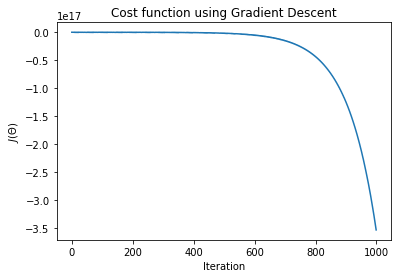

In [114]:
plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

# Plot the data and the decision boundary

In [89]:
def mapFeaturePlot(x1,x2,degree):
    """
    take in numpy array of x1 and x2, return all polynomial terms up to the given degree
    """
    out = np.ones(1)
    for i in range(1,degree+1):
        for j in range(i+1):
            terms= (x1**(i-j) * x2**j)
            out= np.hstack((out,terms))
    return out

Text(0.5, 1.0, 'Lambda =?, alpha=0.5, iterat=?')

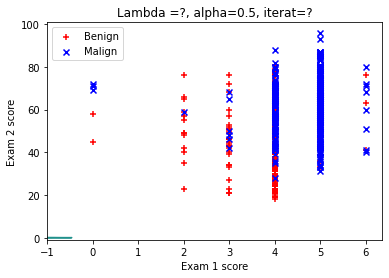

In [90]:
plt.scatter(X[ben]["bi-rads"],X[ben]["age"],c="r",marker="+",label="Benign")
plt.scatter(X[mal]["bi-rads"],X[mal]["age"],c="b",marker="x",label="Malign")

# Plotting decision boundary

u_vals = np.linspace(-1,1.5,50)
v_vals= np.linspace(-1,1.5,50)
z=np.zeros((len(u_vals),len(v_vals)))
for i in range(len(u_vals)):
    for j in range(len(v_vals)):
        z[i,j] =mapFeaturePlot(u_vals[i],v_vals[j],degree) @ theta[1:] +theta[0] 

plt.contour(u_vals,v_vals,z.T,0)
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(loc=0)
plt.title('Lambda =?, alpha=0.5, iterat=?')

### Model accuracy on train data

In [91]:
def classifierPredict(theta,X):
    """
    take in numpy array of theta and X and predict the class 
    """
    h = np.dot(X, theta)
    
    return h>0

In [92]:
p=classifierPredict(theta,Xmap)

print("Train Accuracy:", (sum(p==y)/len(y)*100)[0],"%") 

Train Accuracy: 55.13626834381551 %


## sklearn library to solve the same problem 

In [93]:
from sklearn.linear_model import LogisticRegression

y=data_n[:,2]

#Ridge Regression (L2 penalty) 
clfL2 = LogisticRegression(penalty="l2") 
clfL2.fit(Xmap,y)
print('Accuracy of log reg classifier with L2 penalty:')
print(clfL2.score(Xmap, y))


#Lasso Regression (L1 penalty) 
clfL1 = LogisticRegression(solver='liblinear',penalty="l1")
clfL1.fit(Xmap,y)
print('Accuracy of log reg classifier with L1 penalty:')
print(clfL1.score(Xmap, y))

/home/alexa/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of log reg classifier with L2 penalty:
0.4192872117400419
Accuracy of log reg classifier with L1 penalty:
0.5052410901467506


/home/alexa/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
